# BLS

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.stats import BoxLeastSquares

import warnings
warnings.filterwarnings('ignore')


In [5]:
LC = pd.read_csv ('https://asas-sn.osu.edu/sky-patrol/coordinate/044d7a1e-1073-4f3e-88c8-b18178ae4f34/export.csv')
LC.rename(columns={'HJD': 'time', 'UT Date': 'UT_Date'}, inplace=True) #REMOVE TEH Empty space!!!
data = LC[(LC['flux(mJy)'] < 99) * (LC['flux(mJy)'] > 8) * (LC['flux_err'] < 0.4)] #filtering. (also could remove outliers)

#define usable lightcurve including time,flux,flux_err
raw_lc = lk.LightCurve(time= data['time'] -2400000, 
                   flux= data['flux(mJy)'], #sigma_clip(LC['flux(mJy)'],cenfunc='mean', sigma=2, maxiters=3), 
                   flux_err =data['flux_err'] < 0.5)
#flatten the light curve to get all data to same base line
flat_lc = raw_lc.flatten(window_length=401)


Text(0.5, 1.0, 'Raw manually filtered ASAS-SN V+g')

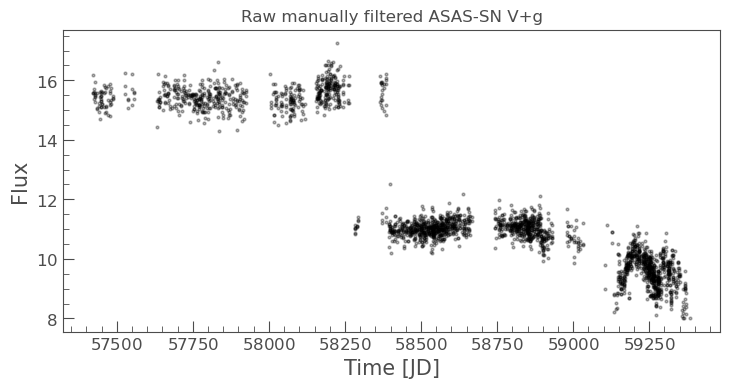

In [16]:
raw_lc.plot(linewidth = 0, marker = 'o',color = 'k', alpha = 0.3)
plt.title('Raw manually filtered ASAS-SN V+g')

In [ ]:
outliers_lc = LC

Text(0.5, 1.0, 'Flattened and combined ASAS-SN V+g')

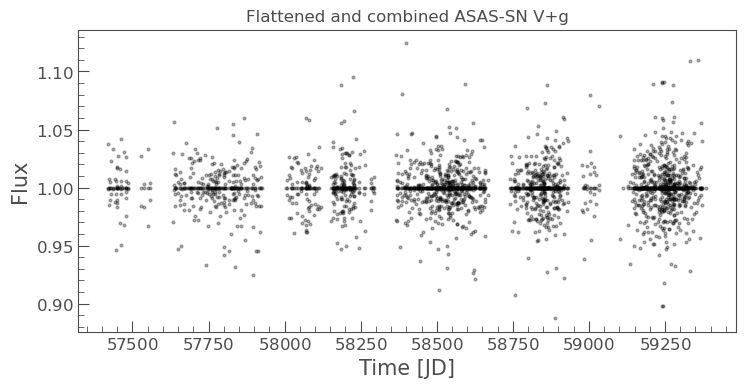

In [12]:
flat_lc.plot(linewidth = 0, marker = 'o',color = 'k', alpha = 0.3)
plt.title('Flattened and combined ASAS-SN V+g')

In [35]:
def plot_bls(alltime, allflux, alltimebinned, allfluxbinned, model, results, period, duration, t0, mid_transit_t0, in_transit = [0], in_transit_notbinned = [0]):
    '''
    Plot the BLS. This functinon is called in data_bls().

    Parameters
    ----------
    alltime  :  list
        times (not binned)
    allflux  :  list
        normalized flux (not binned)
    alltimebinned  :  list
        binned time
    allfluxbinned  :  list
        normalized binned flux
    model :  float
        the transit model at the given period, duration, and phase
    results :  class
        results from the BLS fitting routine
    period :  float
        the period of the 'most-likely' transits
    duration :  float
        the duration of the transit
    t0  :  float
        the mid-transit time of the reference transit
    in_transit = [0] :  float
        if this is [0] (by deafult), the code knows that this is the initial run i.e. no transits have been removes (+ results are plotted in different colors)
    in_transit_notbinned = [0]. :  float
        if this is [0] (by deafult), the code knows that this is the initial run i.e. no transits have been removes (+ results are plotted in different colors)

    Returns
    -------
        Plot the results from the BLS with three pannels: periodgram, best fit model to the transits, phase folded fit.
    '''

    if len(in_transit) == 1:  
        
        color1 = '#DC143C'
        color2 = 'darkorange'
        title = 'Initial BLS'

    else:  
        
        color1 = 'deepskyblue'
        color2 = '#4682B4'
        title = 'Initial event removed'
        

    fig, axes = plt.subplots(3, 1, figsize=(5, 7))

    # highlight the harmonics of the peak period
    ax = axes[0]
    ax.axvline(period, alpha=0.4, lw=5, color = color1)
    for n in range(2, 15):
        ax.axvline(n*period, alpha=0.4, lw=2, linestyle="dashed", color = color2) # plot the harmonics
        ax.axvline(period / n, alpha=0.4, lw=2, linestyle="dashed", color = color2)

    # ------------
    # plot the periodogram
    ax.plot(results.period, results.power, "k", lw=0.5, label = 'P = %.3f T0 = %.3f' % (period,mid_transit_t0))
    ax.set_title(title)
    ax.set_xlim(results.period.min(), results.period.max())
    ax.set_xlabel("period (days)")
    ax.set_ylabel("log likelihood")
    ax.legend(fontsize = 10, loc = 1)

    # ------------
    # plot the light curve and best-fit model
    ax = axes[1]

    if len(in_transit) == 1:  # for the initial run
        ax.plot(alltime, allflux, marker =".", alpha = 0.4, color = color2, ms=2, lw = 0, MarkerFaceColor = 'none')
        ax.plot(alltimebinned, allfluxbinned, marker ="o", alpha = 0.6, color = 'black', ms=3, lw = 0, MarkerFaceColor = 'none')
    else:  # for the second run (once the first 'event' has been removed)
        ax.plot(alltime[~in_transit_notbinned], allflux[~in_transit_notbinned], marker =".", alpha = 0.4, color = color2, ms=2, lw = 0, MarkerFaceColor = 'none')
        ax.plot(alltimebinned[~in_transit], allfluxbinned[~in_transit], marker ="o", alpha = 0.6, color = 'black',  MarkerFaceColor = 'none', ms=3, lw = 0)

    x = np.linspace(alltimebinned.min(), alltimebinned.max(), 3*len(alltimebinned))
    f = model.model(x, period, duration, t0)
    ax.plot(x, f, lw=2, color = color1)
    ax.set_xlim(alltimebinned.min(), alltimebinned.max())
    ax.set_xlabel("time (days)")
    ax.set_ylabel("de-trended flux (ppt)");

    # ------------
    ax = axes[2]
    if len(in_transit) == 1:  # for the initial run
        x_binned = (alltimebinned - t0 + 0.5*period) % period - 0.5*period
        x = (alltime - t0 + 0.5*period) % period - 0.5*period
    else: # for the second run (once the first 'event' has been removed)
        x_binned = (alltimebinned[~in_transit] - t0 + 0.5*period) % period - 0.5*period
        x = (alltime[~in_transit_notbinned] - t0 + 0.5*period) % period - 0.5*period

    m_binned = np.abs(x_binned) < 0.5
    m = np.abs(x) < 0.5

    # plot the data
    if len(in_transit) == 1:  # for the initial run
        ax.plot(x[m], allflux[m],marker =".", alpha = 0.4, color = color2, ms=2, lw = 0, MarkerFaceColor = 'none')
        ax.plot(x_binned[m_binned], allfluxbinned[m_binned], marker ="o", alpha = 0.6, color = 'black', ms=3, lw = 0, MarkerFaceColor = 'none')

    else: # for the second run (once the first 'event' has been removed)
        ax.plot(x[m], allflux[~in_transit_notbinned][m],marker =".", alpha = 0.4, color = color2, ms=2, lw = 0, MarkerFaceColor = 'none')
        ax.plot(x_binned[m_binned], allfluxbinned[~in_transit][m_binned], marker ="o", alpha = 0.6, color = 'black', ms=3, lw = 0, MarkerFaceColor = 'none')

    x = np.linspace(-0.5, 0.5, 1000)
    f = model.model(x + t0, period, duration, t0)
    ax.plot(x, f, lw=2, color = color1)
    ax.set_xlim(-0.5, 0.5)
    ax.set_xlabel("time since transit (days)")
    ax.set_ylabel("de-trended flux (ppt)");
    plt.tight_layout()

    plt.show()
    plt.savefig("test.pdf")




In [36]:
# you don't have to change the code in this cell, but you do have to run it once for the rest of the notebook to work
def data_bls(lc):
    '''
    function that runs the BLS routine and plots the results. The BLS is run twice and in the second
    the most significant result found in the first run is removed.
    Prior to running the BLS the data is detrended.

    Parameters
    ----------
    lc: from lightkurve for one or more sectors 

    Returns
    -------
        two lists of the statistics of the to BLS runs. Each list contains:
    stats_period
    stats_t0
    stats_depth
    stats_depth_phased
    stats_depth_half
    stats_depth_odd
    stats_depth_even
    '''
    
    # normalize the data
    try:
        lc = lc.normalize()
    except:
        lc = lc.stitch()
        
    alltime = lc.time.value
    allflux = lc.flux.value
    
    lc_bin = lc.bin(15/60/24) # you can change the binning factor here if you like
    alltimebinned = lc_bin.time.value
    allfluxbinned = lc_bin.flux.value
        
    # make sure that there are no nan (empty) values in the data - they cause everything to crash so let's get rid of them
    mask_binned = np.isfinite(alltimebinned) * np.isfinite(allfluxbinned)
    mask = np.isfinite(alltime) * np.isfinite(allflux)

    alltimebinned = np.array(alltimebinned)[mask_binned]
    allfluxbinned = np.array(allfluxbinned)[mask_binned]
    alltime = np.array(alltime)[mask]
    allflux = np.array(allflux)[mask]

    # -------------------

    # detrend the data before running the BLS

    mask_binned = np.isfinite(alltimebinned) * np.isfinite(allfluxbinned)
    alltimebinned = np.array(alltimebinned)[mask_binned]
    allfluxbinned = np.array(allfluxbinned)[mask_binned]
    # -----------------------

    durations = np.linspace(0.05, 0.5, 15) # ????? CHECK THESE
    periods = np.arange(0.7, (np.nanmax(alltimebinned) - np.nanmin(alltimebinned)), 0.01)
    
    model = BoxLeastSquares(alltimebinned, allfluxbinned)
    results = model.power(periods, durations)

    index = np.argmax(results.power)
    period = results.period[index]
    t0 = results.transit_time[index]
    duration = results.duration[index]
    mid_transit_t0 = model.compute_stats(period, duration, t0)['transit_times'][0]

    # call the first round of plotting

    plot_bls(alltime, allflux, alltimebinned, allfluxbinned, model, results, period, duration, t0, mid_transit_t0)

    stats_period = period
    stats_t0 = mid_transit_t0
    stats_depth = model.compute_stats(period, duration, t0)['depth']
    stats_depth_phased = model.compute_stats(period, duration, t0)['depth_phased']
    stats_depth_half = model.compute_stats(period, duration, t0)['depth_half']
    stats_depth_odd = model.compute_stats(period, duration, t0)['depth_odd']
    stats_depth_even = model.compute_stats(period, duration, t0)['depth_even']

    if (1*duration) >= period: # if the 'found' events are very short period, don't rn the BLS twice as the code would crash.
        return [stats_period, stats_t0, stats_depth, stats_depth_phased, stats_depth_half, stats_depth_odd, stats_depth_even], [-999]

    # Find the in-transit points using a longer duration as a buffer to avoid ingress and egress
    in_transit = model.transit_mask(alltimebinned, period, 2*duration, t0)
    in_transit_notbinned = model.transit_mask(alltime, period, 2*duration, t0)
    
    # Re-run the algorithm, and plot the results
    model2 = BoxLeastSquares(alltimebinned[~in_transit], allfluxbinned[~in_transit])
    results2 = model2.power(periods, durations)

    # Extract the parameters of the best-fit model
    index = np.argmax(results2.power)
    period2 = results2.period[index]
    t02 = results2.transit_time[index]
    duration2 = results2.duration[index]
    mid_transit_t02 = model.compute_stats(period2, duration2, t02)['transit_times'][0]
    
    # call the second round of plotting - once the intitial transit has been removed
    plot_bls(alltime, allflux, alltimebinned, allfluxbinned, model2, results2,period2,duration2,t02, mid_transit_t02, in_transit = in_transit, in_transit_notbinned = in_transit_notbinned)
    
    stats2_period = period2
    stats2_t0 = mid_transit_t02
    stats2_depth = model2.compute_stats(period2, duration2, t0)['depth']
    stats2_depth_phased = model2.compute_stats(period2, duration2, t0)['depth_phased']
    stats2_depth_half = model2.compute_stats(period2, duration2, t0)['depth_half']
    stats2_depth_odd = model2.compute_stats(period2, duration2, t0)['depth_odd']
    stats2_depth_even = model2.compute_stats(period2, duration2, t0)['depth_even']
        
    df = pd.DataFrame({"Period (days)": [stats_period,stats2_period], "T0 (TBJD)":[stats_t0,stats2_t0], "Transit depth (ppm)":[stats_depth[0],stats2_depth[0]], "Odd depth (ppm)": [stats_depth_odd[0],stats2_depth_odd[0]], "Even depth (ppm)":[stats_depth_even[0],stats2_depth_even[0]]})
    return df

    plt.savefig("test.pdf")


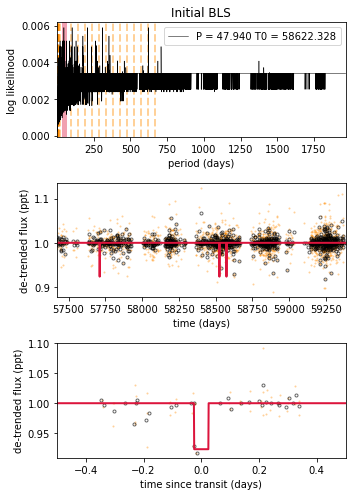

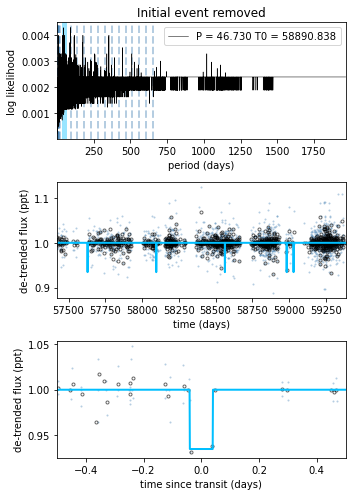

Some statistics about the two fits (these numbers are just estimates and should be taken with a large pinch of salt!)


,Period (days),T0 (TBJD),Transit depth (ppm),Odd depth (ppm),Even depth (ppm)
0,47.94,58622.328328,0.076758,0.071105,0.082410
1,46.73,58890.838328,-0.004317,-0.016943,-0.000108


In [7]:
df = data_bls(flat_lc)
Print('Suggestive periods below:')

df


Still inconclusive? But at least I got tools working! **Always check this panel to see whether there is a signal or whether the algorithms found noise!** and the dips are too deep. 

Lets try and fold this

In [25]:
period = 47.94
t0 = 58622.328328

In [26]:
folded1 = raw_lc.fold(period =period, epoch_time = t0)

(-1.0, 1.0)

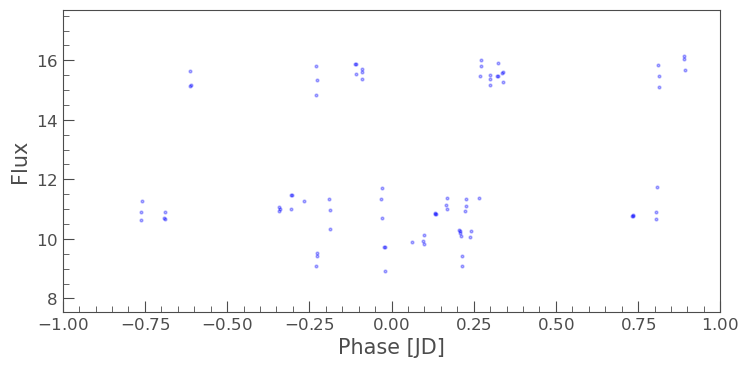

In [27]:
folded1.plot(linewidth = 0, marker = 'o',color = 'blue', alpha = 0.3)
plt.xlim(-1,1)
#plt.ylim(0.85,1.20)

In [33]:
plt.savefig("plots.pdf")


<Figure size 432x288 with 0 Axes>